# All you need to know about Regularization (and some tips on optimization)

One of the major aspects of training your machine learning model is avoiding **overfitting**. The model will have a low accuracy if it is overfitting. This happens because your model is trying too hard to capture the noise in your training dataset. By noise we mean the data points that don’t really represent the true properties of your data, but random chance. Learning such data points, makes your model more flexible, at the risk of overfitting.

<img src="https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2018/04/Screen-Shot-2018-04-03-at-7.52.01-PM-e1522832332857.png" style="float:center; width: 800px"/>

# 1 Bias and Variance trade-off

Suppose we have a statistical model, parameterized by a real number $\theta$, giving rise to a probability distribution for observed data, $P_{\theta }(x)=P(x\mid \theta )$, and a statistic $\hat {\theta }$ which serves as an estimator of $\theta$ based on any observed data $x$.

## Bias: 

It is the difference between this estimator’s expected value and the true value of the parameter being estimated. More formally, this is defined as:

$$\text{bias}(\mathbf{\hat\theta}_m) = \mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m] - \mathbf{\theta}= \mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m - \mathbf{\theta}],$$

where the expectation is taken over the dataset (viewed as samples of a random variable).

Please note that **an estimator is unbiased** if $\mathbb{E}[\mathbf{\hat\theta}_m] = \mathbf{\theta}.$

## Variance:
Similarly, the variance is defined as

$$\text{var}(\mathbf{\hat\theta}_m) = \mathbb{E}_{x\mid \theta }[(\mathbf{\hat\theta}_m)^2] - \left(\mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m]\right)^2.$$

The variance or standard error of an estimator is a measure of much we expect the output of our estimator to vary as a function of independent resampling of data from the data generating distribution. Just as we might like an estimator to exhibit low bias, we might also want it to have low variance.

Note that, since  $\mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m] = \text{bias}(\mathbf{\hat\theta}_m) + \mathbf{\theta}$, we can write the variance as:

$$\text{var}(\mathbf{\hat\theta}_m) = \mathbb{E}_{x\mid \theta }[(\mathbf{\hat\theta}_m)^2] - \left(\mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m]\right)^2 = 
\mathbb{E}_{x\mid \theta }[(\mathbf{\hat\theta}_m)^2] - \left(\text{bias}(\mathbf{\hat\theta}_m) + \mathbf{\theta}\right)^2= \mathbb{E}_{x\mid \theta }[(\mathbf{\hat\theta}_m)^2] - \left(\text{bias}(\mathbf{\hat\theta}_m)\right)^2 +\theta^2-2\theta\mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m] $$

**Therefore, we have that the error is composed of both the bias and variance!!**

$$\text{var}(\mathbf{\hat\theta}_m)+\left(\text{bias}(\mathbf{\hat\theta}_m)\right)^2 = 
\mathbb{E}_{x\mid \theta }[(\mathbf{\hat\theta}_m)^2] +\theta^2-2\theta\mathbb{E}_{x\mid \theta }[\mathbf{\hat\theta}_m] = \mathbb{E}_{x\mid \theta }\left[(\hat\theta_m -\theta)^2\right]$$

The bias–variance dilemma is the conflict in trying to simultaneously minimize these two sources of error that prevent supervised learning algorithms from generalizing beyond their training set:

* The bias is an error from erroneous assumptions in the learning algorithm. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).
* The variance is an error from sensitivity to small fluctuations in the training set. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

Thus, complex models will tend to have low bias and high variance, while simple models will present low variance and high bias (see the figure below).

<img src="https://djsaunde.files.wordpress.com/2017/07/bias-variance-tradeoff.png" style="float:center; width: 600px"/>


Translating these ideas to ML, if we would look at the errors in train and test of a set of models (of increasing capacity), we would see that at a certain point the error in the validation dataset starts to increase, while the error in train continues to go down:

<img src="https://i.stack.imgur.com/ZTQSP.png" style="float:center; width: 600px"/>

## 1.1 Let's implement that!

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from keras.callbacks import TensorBoard
import os
from time import time
import shutil
import keras as K

Using TensorFlow backend.


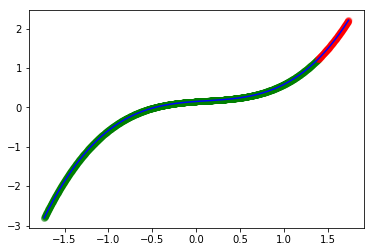

In [2]:
# generate simple data with noise from a gaussian distribution and fit increasingly complicated functions
# f = lambda x: np.cos(x)
# x_train = np.linspace(-3*np.pi,2*np.pi,5000)
# y_train = f(x_train)+ np.random.normal(loc=0.0, scale=0.1, size=x_train.size)

f = lambda x: -10+3*x-x**2+x**3
x_train = np.linspace(-5.0,5.0,5000)
y_train = f(x_train)+ np.random.normal(loc=0.0, scale=0.1, size=x_train.size)

x_train_norm = (x_train-x_train.mean())/(x_train.std())
y_train_norm = (y_train-y_train.mean())/(y_train.std()) 


x_train_shuffle = x_train_norm.copy()
y_train_shuffle = y_train_norm.copy()

shuffle = False
if shuffle:
    np.random.seed(187)
    np.random.shuffle(x_train_shuffle)
    np.random.seed(187)
    np.random.shuffle(y_train_shuffle)

val_split = 0.1    
train_size = int(x_train_shuffle.size*(1-val_split))
plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
plt.plot(x_train_norm, (f(x_train)-np.mean(f(x_train)))/np.std(f(x_train)), 'b');

In [3]:
log_dir = "/tmp/dl4ks/logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
else:
    shutil.rmtree(log_dir)
    os.makedirs(log_dir)

In [4]:
def train_model(layers=1, neurons=64, act='relu', lr=1e-3, epochs=50, batch_size=100, split=0.2,
                clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act))
    m.add(K.layers.Dense(1, activation=act))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'no_reg/act={}/layers={}_neurons={}'.format(act, layers, neurons)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

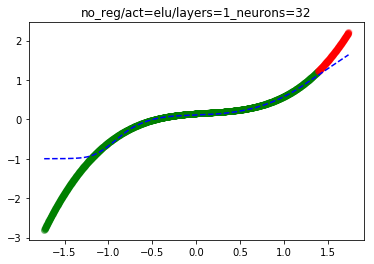

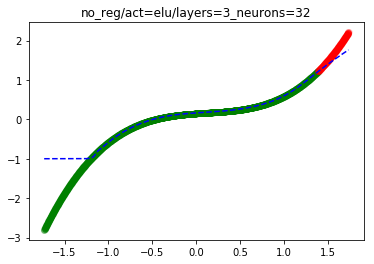

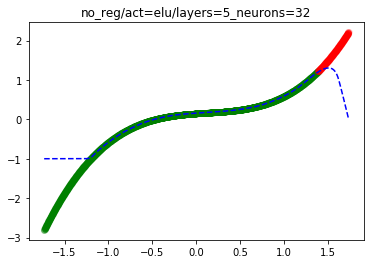

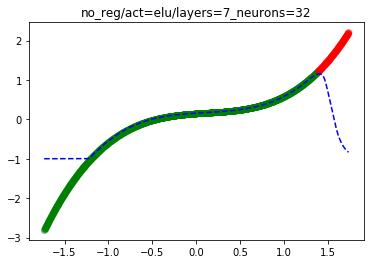

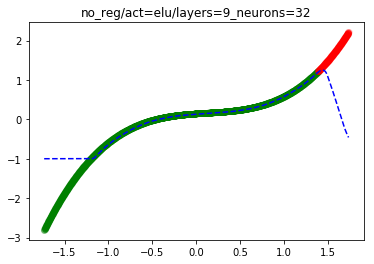

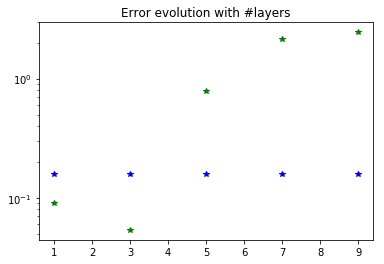

In [5]:
err_train = []
err_val = []
num_layers = np.arange(1, 10, 2)
for i in num_layers:
    _, et, ev = train_model(layers=i, neurons=32, act='elu', lr=1e-3, epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution with #layers")
plt.semilogy(num_layers, err_train, '*b')
plt.semilogy(num_layers, err_val, '*g')
plt.show()

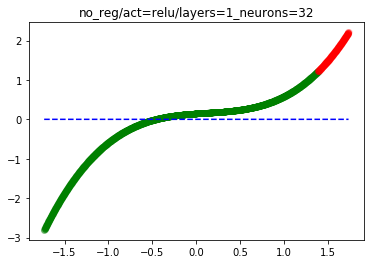

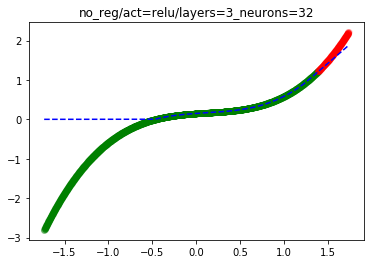

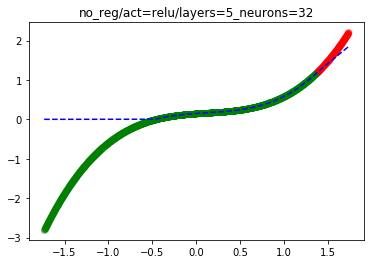

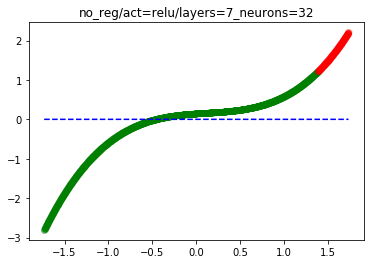

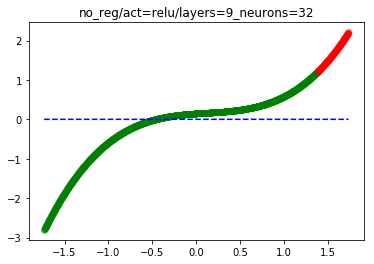

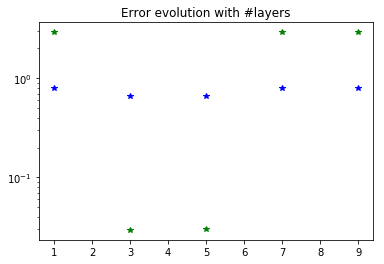

In [6]:
err_train = []
err_val = []
num_layers = np.arange(1, 10, 2)
for i in num_layers:
    _, et, ev = train_model(layers=i, neurons=32, act='relu', lr=1e-3, epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution with #layers")
plt.semilogy(num_layers, err_train, '*b')
plt.semilogy(num_layers, err_val, '*g')
plt.show()

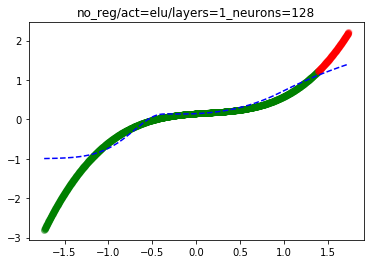

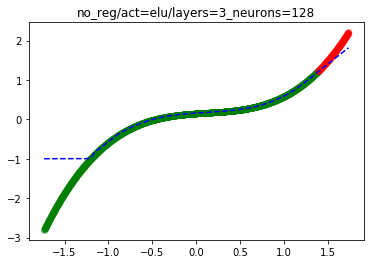

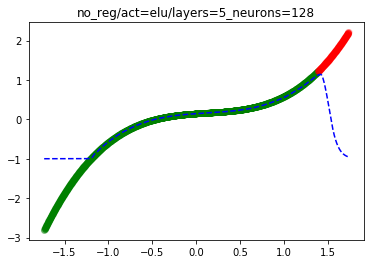

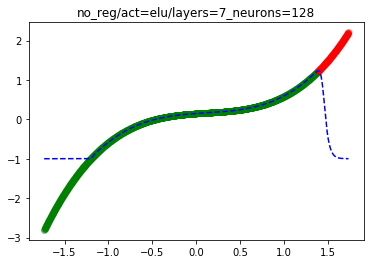

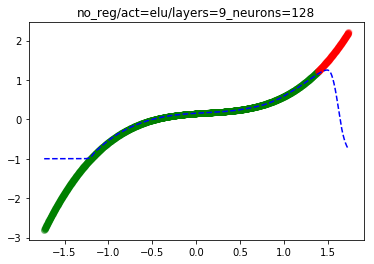

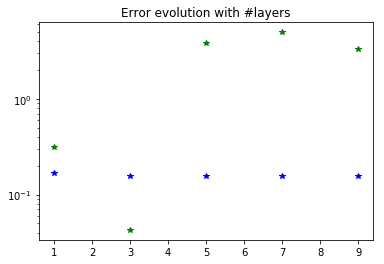

In [7]:
err_train = []
err_val = []
num_layers = np.arange(1, 10, 2)
for i in num_layers:
    _, et, ev = train_model(layers=i, neurons=128, act='elu', lr=1e-3, epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution with #layers")
plt.semilogy(num_layers, err_train, '*b')
plt.semilogy(num_layers, err_val, '*g')
plt.show()

# 2. Regularization to the rescue!

What is exactly regularizing a model? From wikipedia:

### *Regularization is a process of introducing additional information in order to solve an ill-posed problem or to prevent overfitting.*

But, what is additional information? Actually, anything that improves generalization:

* Any prior introduced in your modeling. 
* Gradient smoothing 
* A constraint on the learnable parameters.
* A penalty on the learnable parameters.
* An ensamble of models (bootstrap aggregation, drop out, etc.)
* Data augmentation (more data, put in different ways, incrxeases generalization)
* Noise injection (generalization induced by robstness against noise)
* Parameter tying and sharing (e.g. in CNN, which share the kernels)
* Multitask learning (forcing a representation to be good at several tasks helps improving generalization)
* Early stopping
* Sparse actvations (similar to L1 penalty, but on the activations)
* Adversarial training (look for adversarial examples to prevent them)
* You name it!!

Indeed, optimization improvements can be shown to also regularize the model:
* A new SGD method may regularize the learning process (e.g., if you incorporate 2nd order information).
* Loss landscape optimization
* Normalization techniques (input, weigths, activations, etc.)

In this lesson, we will cover the following regularization and optimization techniques:
* Weight and bias regularization (via L1/L2 norm penalties)
* Weight and gradient constraints (max-norm and gradient clipping)
* Drop out
* Batch normalization
* Self normalizing Exponential Linear Units
* Smart scheduling of the Learning Rate


We will also talk about the batch-normalization, internal covariate shift and Self-normalized exponential linear units (Selu)

The best resource is [Chapter 7 of the book *Deep Learning*](http://www.deeplearningbook.org/contents/regularization.html), 
and of course the [Keras documentation](https://keras.io/regularizers/).

# 2.1 Weight penalties

Recall that MSE is composed of the *bias and variance errors*. Since we want to use complex models that reduce the bias, one simple way of reducing the associated variance would be to put a penalty on the weights, so that to make them small or even zero:

$$\mathcal{L} = \mathcal{L}(y, \hat{y}) + \lambda \sum_m L_q(\theta_m),$$

with $L_q(\theta_m) = ||\theta_m||_q$ the q-norm of the parameter (tensor) $\theta_m$:

* $L_1 =\sum_i |\theta_i|$ (known also as Lasso regression)
* $L_2 = \sum_i \theta_i^2$ (known also as Ridge regression, or weight-decay)
* $L_\infty = \max_i |\theta_i|$

Note that the parameter $\lambda$ measures the strength of the regularization. For a given value of the loss, there is a value of $\lambda$ that makes both terms to compete. On the other hand, large values of $\lambda$ might limit the capacity of the model (underfitting), while small ones can produce the model to learn freely (and thus, overfit). 

Generally speaking, the optimization of the regularization term $\lambda \sum_m L_q(\theta_m)$ will tend to make $\theta_m \rightarrow 0$. However, there are subtle differences on how this is made. 

The $L_2$ norm tends to make all weights to have values below 1, since they contribute quadratically to the loss. On the other hand, the $L_1$ loss contributes linearly to the loss, and thus even values below 1 can contribute significantly to the total loss (we might have millions of parameters!). This is the reason why we'll typically observe actual zeros for some parameters under $L_1$ regularization. Therefore, $L_1$ can be used as a feture selector form of regularization, whenever you have a very high dimensional input problem. Finally, the $L_\infty$ norm is not commonly used (computationally expensive and inefficient).  

In [8]:
shutil.rmtree(log_dir)
os.makedirs(log_dir)

In [9]:
from keras.regularizers import l1_l2

In [10]:
def train_model(layers=1, neurons=64, act='relu', lr=1e-3, l1=0.0, l2=0.0, epochs=50, batch_size=100, split=0.2,
                clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    m.add(K.layers.Dense(1, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2)))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg/act={}/layers={}_neurons={}_l1={}_l2={}'.format(act, layers, neurons, l1, l2)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

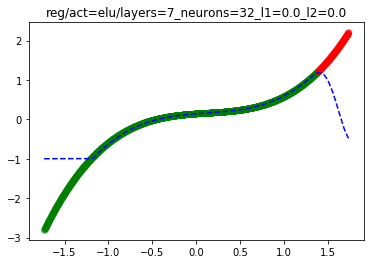

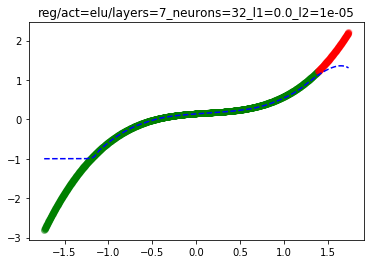

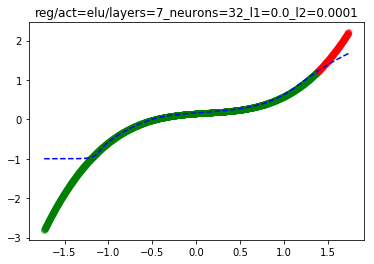

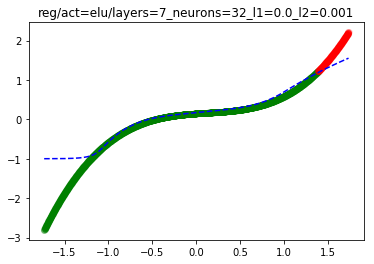

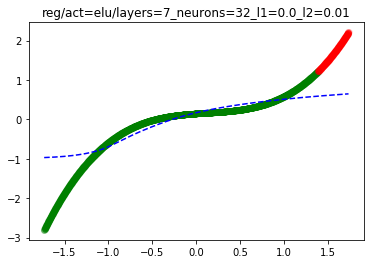

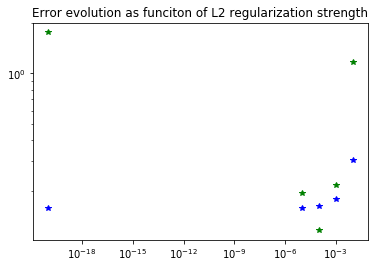

In [11]:
err_train = []
err_val = []
num_layers = 7
l1 = 0.0
l2_list = [0.0, 1e-5, 1e-4, 1e-3, 1e-2]
for l2 in l2_list:
    _, et, ev = train_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, l1=l1, l2=l2,
                            epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of L2 regularization strength")
plt.loglog([1e-20]+l2_list[1:], err_train, '*b')
plt.loglog([1e-20]+l2_list[1:], err_val, '*g')
plt.show()

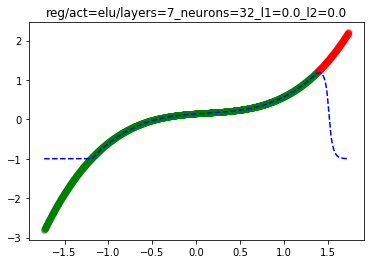

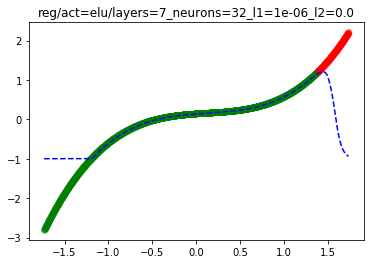

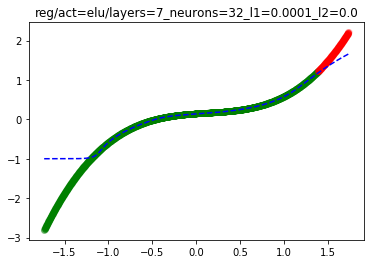

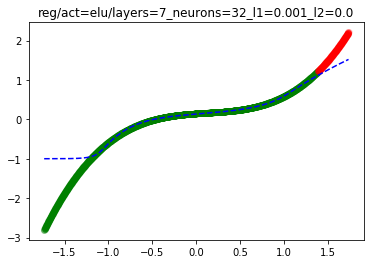

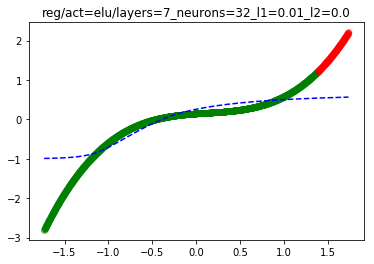

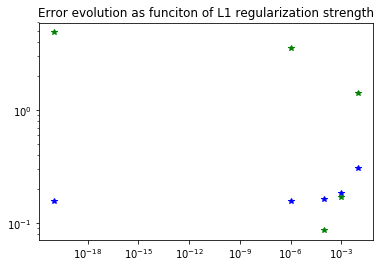

In [12]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1_list = [0.0, 1e-6, 1e-4, 1e-3, 1e-2]
for l1 in l1_list:
    _, et, ev = train_model(layers=num_layers, neurons=32, act='elu', lr=5e-4, l1=l1, l2=l2,
                            epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of L1 regularization strength")
plt.loglog([1e-20]+l1_list[1:], err_train, '*b')
plt.loglog([1e-20]+l1_list[1:], err_val, '*g')
plt.show()

# 2.2 Weight constraints

Why should we have to force our values to be small or even zero? Why don't just limit their value to be below some threshold that prevents gradients to explode?

This is what *max norm* regularization is meant for =) Basically, it clips the values of a parameter whenever they reach some maximum value. More specifically, max norm is applied to a whole dimension; for instance, to the rows or columns of a matrix. 

MAx norm was introduce of Matrix Factorization applied to Recommender Systems, but become popular in NN after Hinton and coworkers use it in their famous [Dropout paper](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf). See this [thread of Ian Goodfellow on Google+ (2013)](https://plus.google.com/+IanGoodfellow/posts/QUaCJfvDpni):

<blockquote>
One useful neural network trick I picked up from Geoff Hinton's arXiv paper on dropout is using a hard inequality constraint on the norm of the weight vector going into each hidden unit, rather than adding a term to the objective function penalizing the sum of the squares of the weights.    
</blockquote>    

A nice theoretical property of max-norm is that you can use larger learning rates to update your parameters. Also, it does not depend on the value of the loss, making it easier to use than $L_2$ regularization. 

In [13]:
shutil.rmtree(log_dir)
os.makedirs(log_dir)

In [14]:
from keras.constraints import max_norm

In [15]:
def train_model(layers=1, neurons=64, act='relu', lr=1e-3, l1=0.0, l2=0.0, mn=0.0, epochs=50, batch_size=100, split=0.2,
                clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                             kernel_constraint=max_norm(mn) if mn>0.0 else None))
    m.add(K.layers.Dense(1, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg/act={}/layers={}_neurons={}_l1={}_l2={}_mn={}'.format(act, layers, neurons, l1, l2, mn)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

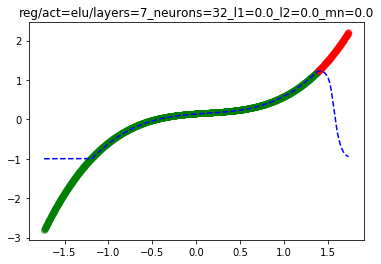

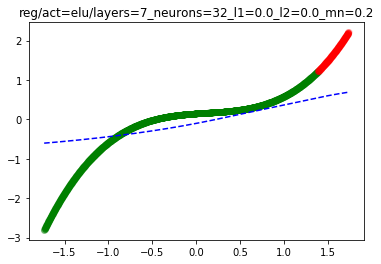

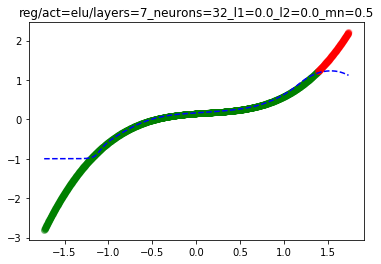

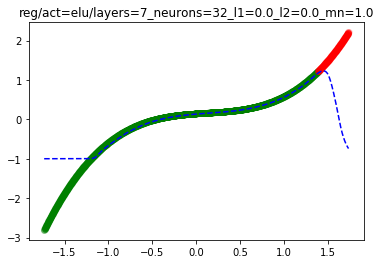

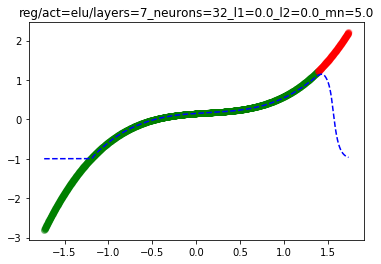

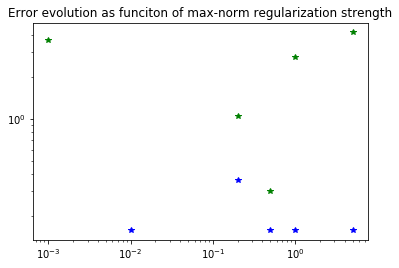

In [16]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = [0.0, 0.2, 0.5, 1.0, 5.0]
for mx in mn:
    _, et, ev = train_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mx,
                            epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-2]+mn[1:], err_train, '*b')
plt.loglog([1e-3]+mn[1:], err_val, '*g')
plt.show()

### There are many other constraints available in the [Keras API](https://keras.io/constraints/), play with them!

# 2.3 Drop-out: a clever way of ensembling models!

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: [A Simple Way to Prevent Neural Networks from Overfitting](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf).

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

*What is trying to solve Dropout? Too much specialization can be bad...*

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some **specialization**. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network. 

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

Note that **dropout is performing an ensamble of smaller models (representations)**, adding thus redundance and averaging possible mistakes made by each representation. Therefore, *it only make sense to use it when your model is way larger than the expected optimal capacity*.

In [17]:
shutil.rmtree(log_dir)
os.makedirs(log_dir)

In [18]:
def train_model(layers=1, neurons=64, act='relu', lr=1e-3, l1=0.0, l2=0.0, mn=0.0, drop_out=0.0,
                epochs=50, batch_size=100, split=0.2,
                clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    m.add(K.layers.Dropout(drop_out))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                             kernel_constraint=max_norm(mn) if mn>0.0 else None))
        m.add(K.layers.Dropout(drop_out))
    m.add(K.layers.Dense(1, activation=act, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg/act={}/layers={}_neurons={}_l1={}_l2={}_mn={}_drop={}'.format(act, layers, neurons, l1, l2, 
                                                                              mn, drop_out)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

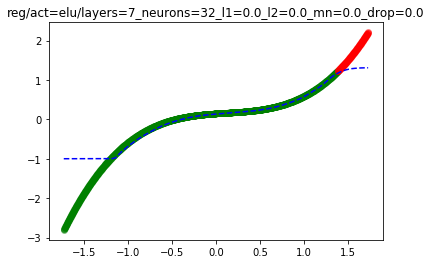

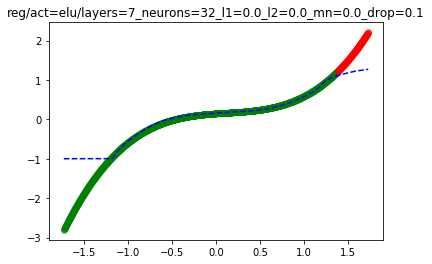

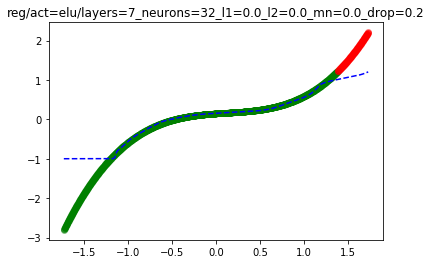

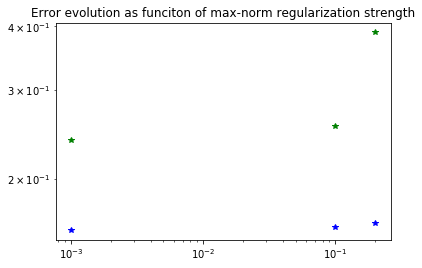

In [19]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = 0.0
drop = [0.0, 0.1, 0.2]
for d in drop:
    _, et, ev = train_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=d,
                            epochs=200, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-3]+drop[1:], err_train, '*b')
plt.loglog([1e-3]+drop[1:], err_val, '*g')
plt.show()

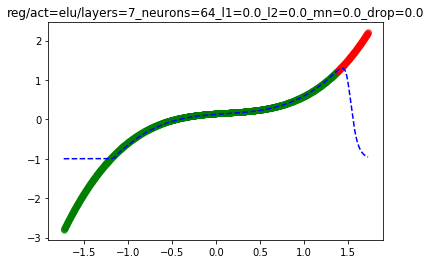

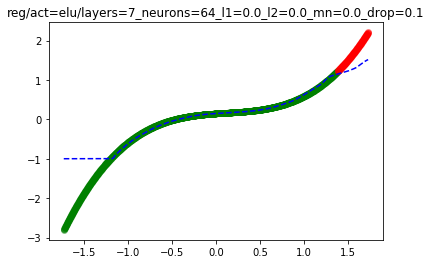

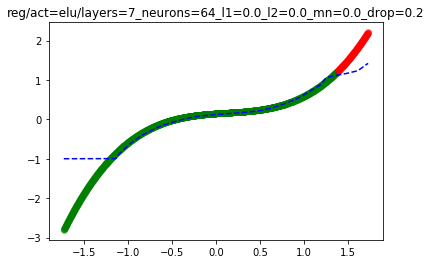

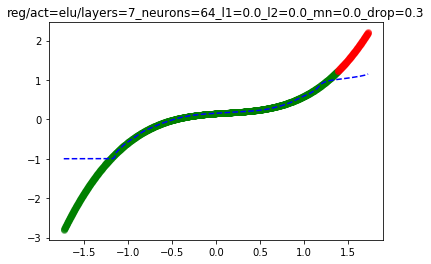

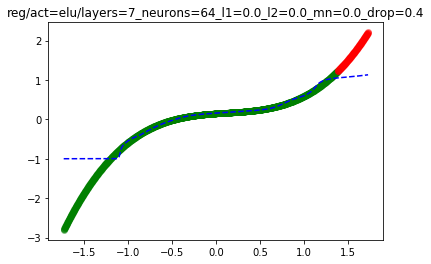

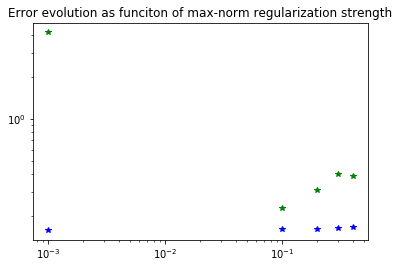

In [20]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = 0.0
drop = [0.0, 0.1, 0.2, 0.3, 0.4]
for d in drop:
    _, et, ev = train_model(layers=num_layers, neurons=64, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=d,
                            epochs=200, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-3]+drop[1:], err_train, '*b')
plt.loglog([1e-3]+drop[1:], err_val, '*g')
plt.show()

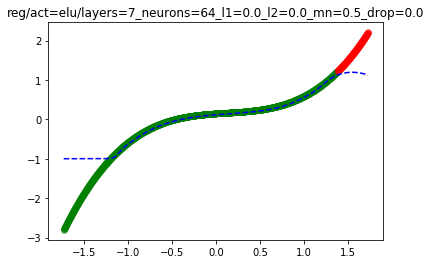

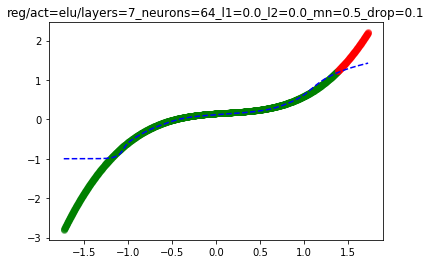

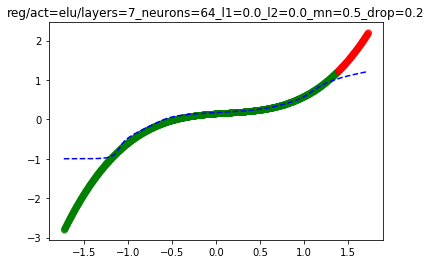

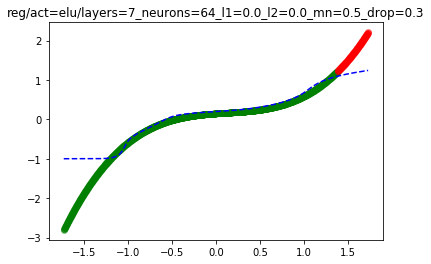

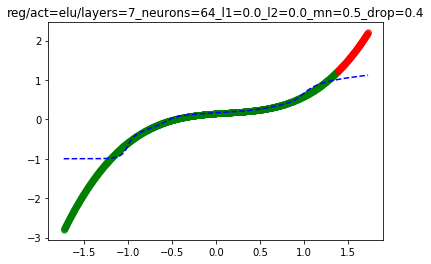

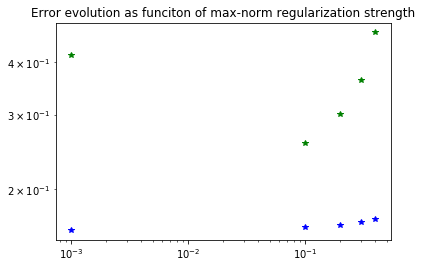

In [21]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = 0.5
drop = [0.0, 0.1, 0.2, 0.3, 0.4]
for d in drop:
    _, et, ev = train_model(layers=num_layers, neurons=64, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=d,
                            epochs=200, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-3]+drop[1:], err_train, '*b')
plt.loglog([1e-3]+drop[1:], err_val, '*g')
plt.show()

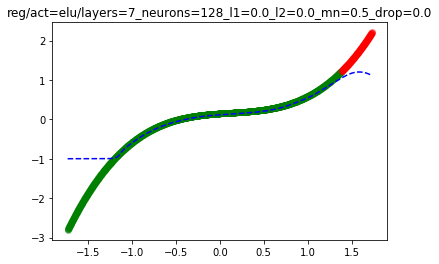

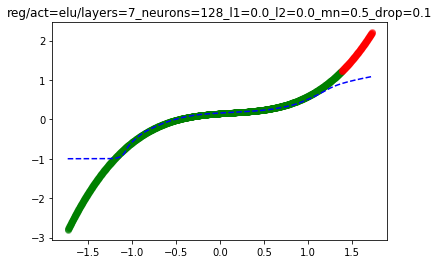

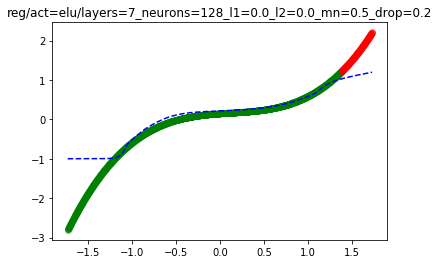

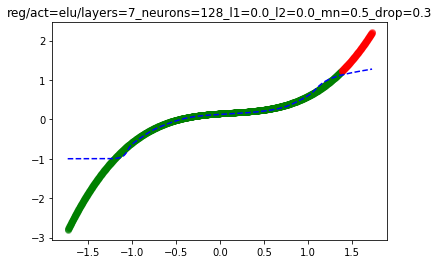

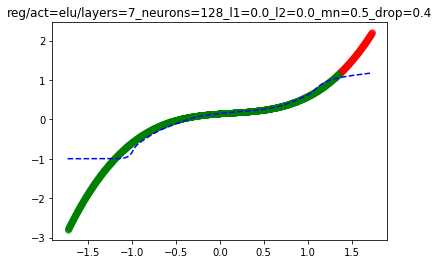

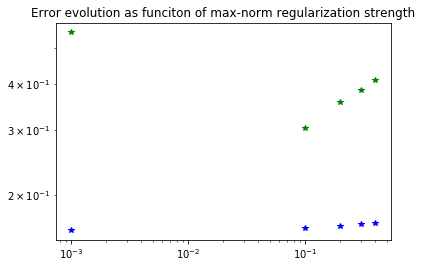

In [22]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = 0.5
drop = [0.0, 0.1, 0.2, 0.3, 0.4]
for d in drop:
    _, et, ev = train_model(layers=num_layers, neurons=128, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=d,
                            epochs=200, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-3]+drop[1:], err_train, '*b')
plt.loglog([1e-3]+drop[1:], err_val, '*g')
plt.show()

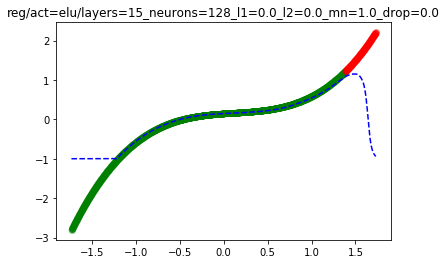

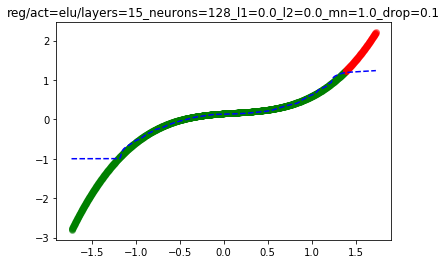

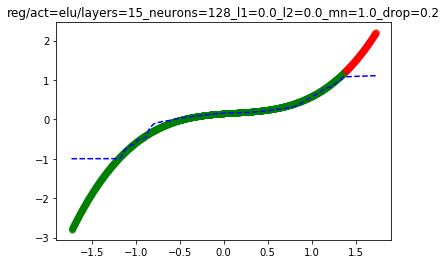

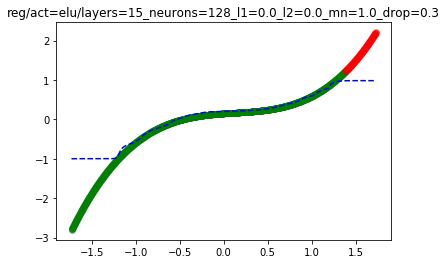

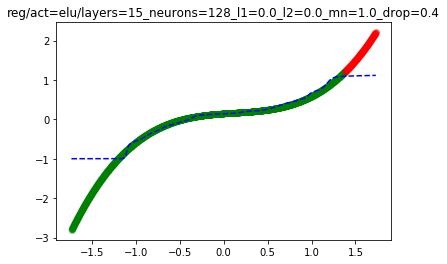

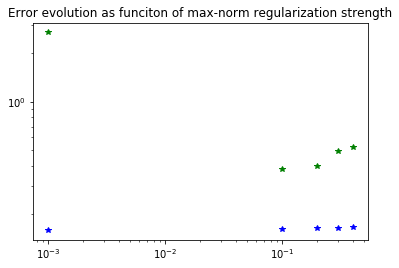

In [23]:
err_train = []
err_val = []
num_layers = 15
l2 = 0.0
l1 = 0.0
mn = 1.0
drop = [0.0, 0.1, 0.2, 0.3, 0.4]
for d in drop:
    _, et, ev = train_model(layers=num_layers, neurons=128, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=d,
                            epochs=300, batch_size=100, split=val_split,
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution as funciton of max-norm regularization strength")
plt.loglog([1e-3]+drop[1:], err_train, '*b')
plt.loglog([1e-3]+drop[1:], err_val, '*g')
plt.show()

# 2.4 Batch normalization

One of the main problems when optimizging deep NN, is that the inputs to a particular hidden layer (imagine, the 10$^{th}$ layer in a DNN consisting of 30 layers) vary a lot, making it hard to produce comparable outputs. Indeed, because of this behaviour, errors may porpagate and accumlate through the layers. As [the autors put it](https://arxiv.org/abs/1502.03167):

<blockquote>
Training Deep Neural Networks is complicated by the fact that the distribution of each layer's inputs changes during training, as the parameters of the previous layers change.     
</blockquote>

This concept (the variance of a layer's values  as the input changes) was named by the autors of BN as the *internal covariate shift*. Indeed, [Andrew NG explains it](https://www.youtube.com/watch?v=nUUqwaxLnWs) with a network classifier trained on black cats, which is then used to classify cats of all colors (see image below). Since the input distributions has change, it will be hard for the network to correctly classify these coloured cats, wouldn't it?

<img src="https://cdn-images-1.medium.com/max/2000/1*VTNB7oSbyaxtIpZ3kXdH4A.png" style="float:center; width: 600px"/>

As the authors said, the internal covariate shift

<blockquote>
This slows down the training by requiring lower learning rates and careful parameter initialization, and makes it notoriously hard to train models with saturating nonlinearities.    
</blockquote>    

One way to address this issue is to standarize (normalize) the input to a layer in each mini-batch. In other words, BN tries to isolate the effect of previous layer's updates. Note that the idea of normalizing the input to a model isn't new: we do that always in every ML model! The contribution of BN is to **normalize the input to each hidden layer**. Mathematically, the updates of BN are as follows:

<img src="https://cdn-images-1.medium.com/max/1600/1*Hiq-rLFGDpESpr8QNsJ1jg.png" style="float:center; width: 600px"/>

BN has a surprising effect: since mean and variance are calculated at mini-batch level, it **introduces some noise in the learning process, [which produces some sort of regularization](https://medium.com/@SeoJaeDuk/deeper-understanding-of-batch-normalization-with-interactive-code-in-tensorflow-manual-back-1d50d6903d35)**.

Note also that the are two new parameters for each layer, the scaling parameter $\gamma$ and the shifting (centering) parameter $\beta$. These two parameters allow arbitrary values of the mean (i.e., $\beta$) and variance (i.e. $\gamma$) as input to the layers, which might ease the learning procedure (overall, to produce outputs in a given interval).

Altough in the original paper BN is performed before applying the activation function, there is some discussion in the academia whether it should be applied [before of after the activation](https://stackoverflow.com/questions/34716454/where-do-i-call-the-batchnormalization-function-in-keras). Nonetheless, most researchers still prefer to use it before the activation.

In [24]:
shutil.rmtree(log_dir)
os.makedirs(log_dir)

In [25]:
from keras.layers.normalization import BatchNormalization

In [26]:
def train_BN_model(layers=1, neurons=64, act='relu', lr=1e-3, center=True, scale=True,
                   l1=0.0, l2=0.0, mn=0.0, drop_out=0.0, 
                   epochs=50, batch_size=100, split=0.2, 
                   clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    m.add(BatchNormalization(center=center, scale=scale))
    m.add(K.layers.Activation(activation=act))
    m.add(K.layers.Dropout(drop_out))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, kernel_regularizer=l1_l2(l1=l1, l2=l2), 
                             kernel_constraint=max_norm(mn) if mn>0.0 else None))
        m.add(BatchNormalization(center=center, scale=scale))
        m.add(K.layers.Activation(activation=act))
        m.add(K.layers.Dropout(drop_out))
    m.add(K.layers.Dense(1, kernel_regularizer=l1_l2(l1=l1, l2=l2),  
                         kernel_constraint=max_norm(mn) if mn>0.0 else None))
    m.add(BatchNormalization(center=center, scale=scale))
    m.add(K.layers.Activation(activation=act))
    m.add(K.layers.Dropout(drop_out))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg_BN/act={}/layers={}_neurons={}_l1={}_l2={}_mn={}_drop={}'.format(act, layers, neurons, l1, l2, 
                                                                              mn, drop_out)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

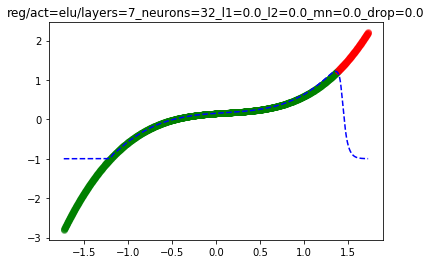

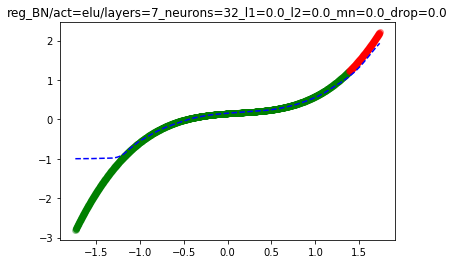

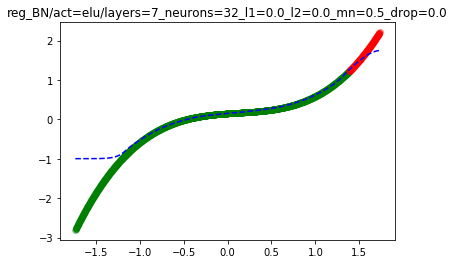

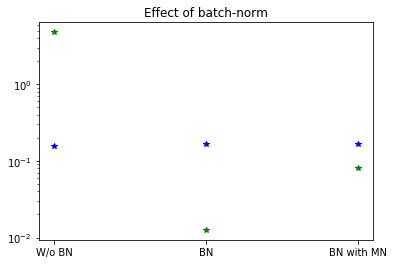

In [27]:
err_train = []
err_val = []
num_layers = 7
l2 = 0.0
l1 = 0.0
mn = 0.0
drop = 0.0

# Standard network
_, et, ev = train_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, l1=l1, l2=l2, mn=mn, drop_out=drop,
                        epochs=300, batch_size=100, split=val_split,
                        clear_session=True, log=True, plot=True, verbose=0)
err_train.append(et)
err_val.append(ev)

# Batch normalized network
_, et, ev = train_BN_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, center=True, scale=True,
                           l1=l1, l2=l2, mn=mn, drop_out=drop, epochs=300, batch_size=100, split=val_split, 
                           clear_session=True, log=True, plot=True, verbose=0)
err_train.append(et)
err_val.append(ev)

# Batch normalized network
_, et, ev = train_BN_model(layers=num_layers, neurons=32, act='elu', lr=1e-3, center=True, scale=True,
                           l1=l1, l2=l2, mn=0.5, drop_out=drop, epochs=300, batch_size=100, split=val_split, 
                           clear_session=True, log=True, plot=True, verbose=0)
err_train.append(et)
err_val.append(ev)

plt.title("Effect of batch-norm")
plt.semilogy([0, 1, 2], err_train, '*b')
plt.semilogy([0, 1, 2], err_val, '*g')
plt.xticks([0, 1, 2], ['W/o BN', 'BN', 'BN with MN'])
plt.show()

# 2.5 Self-normalizing exponential linear Units

Note that we have to chnage the weigths initiazlizer and the drop out schemma.

In [28]:
def train_model_SN(layers=1, neurons=64, act='selu', lr=1e-3, drop_out=0.0, epochs=50, batch_size=100, split=0.2,
                   clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act, kernel_initializer=K.initializers.lecun_normal()))
    m.add(K.layers.AlphaDropout(drop_out))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act, kernel_initializer=K.initializers.lecun_normal()))
        m.add(K.layers.AlphaDropout(drop_out))
    m.add(K.layers.Dense(1, activation=act, kernel_initializer=K.initializers.lecun_normal()))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg/act={}/layers={}_neurons={}_l1={}_l2={}_mn={}_drop={}'.format(act, layers, neurons, l1, l2, 
                                                                              mn, drop_out)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard] if log else None, verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

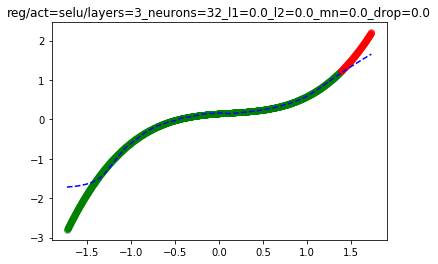

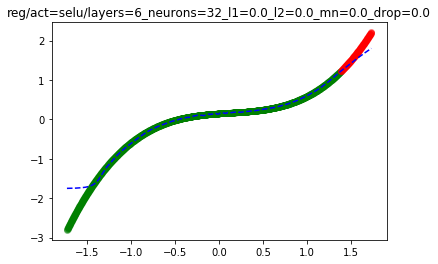

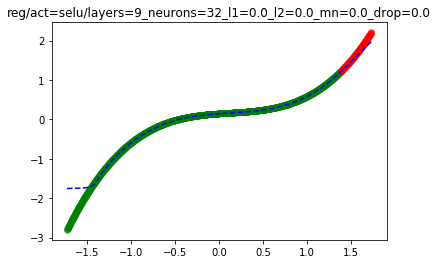

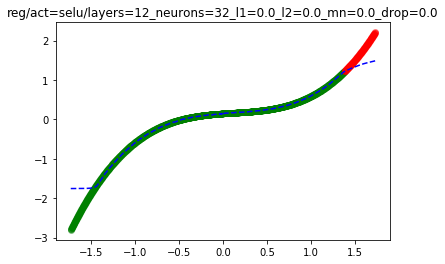

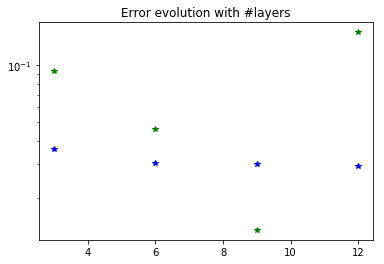

In [29]:
err_train = []
err_val = []
drop = 0.0

num_layers = np.arange(3, 15, 3)
for i in num_layers:
    _, et, ev = train_model(layers=i, neurons=32, act='selu', lr=1e-5, drop_out=drop, 
                            epochs=500, batch_size=100, split=val_split, 
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution with #layers")
plt.semilogy(num_layers, err_train, '*b')
plt.semilogy(num_layers, err_val, '*g')
plt.show()

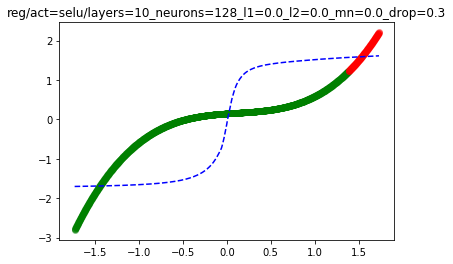

In [30]:
err_train = []
err_val = []
drop = 0.3
num_layers = 10
_, et, ev = train_model(layers=num_layers, neurons=128, act='selu', lr=1e-6, drop_out=drop, 
                        epochs=500, batch_size=100, split=val_split, 
                        clear_session=True, log=True, plot=True, verbose=0)
err_train.append(et)
err_val.append(ev)
    

# 2.6 Smart schedulling  of the learning rate

In [49]:
shutil.rmtree(log_dir)
os.makedirs(log_dir)

In [50]:
from keras.callbacks import ReduceLROnPlateau

In [51]:
def train_model_SN(layers=1, neurons=64, act='selu', lr=1e-3, drop_out=0.0, epochs=50, batch_size=100, split=0.2,
                   clear_session=False, log=True, plot=False, verbose=0):
    if clear_session:
        K.backend.clear_session()
    
    # Build model
    m = K.models.Sequential()
    m.add(K.layers.Dense(neurons, input_shape=(1,), activation=act, kernel_initializer=K.initializers.lecun_normal()))
    m.add(K.layers.AlphaDropout(drop_out))
    for _ in np.arange(layers-1):
        m.add(K.layers.Dense(neurons, activation=act, kernel_initializer=K.initializers.lecun_normal()))
        m.add(K.layers.AlphaDropout(drop_out))
    m.add(K.layers.Dense(1, activation=act, kernel_initializer=K.initializers.lecun_normal()))
    
    # Compile
    m.compile(optimizer=K.optimizers.rmsprop(lr=lr), loss=K.losses.MSE)
    
    # logging
    arch = 'reg/act={}/layers={}_neurons={}_l1={}_l2={}_mn={}_drop={}'.format(act, layers, neurons, l1, l2, 
                                                                              mn, drop_out)
    if log:
        tensorboard = TensorBoard(log_dir=os.path.join(log_dir, arch), histogram_freq=1,  
                                  write_graph=True, write_images=False)
    # TODO parametrize these parameters...
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=1e-6, 
                                  min_delta=1e-3, verbose=0)
    h = m.fit(x_train_shuffle, y_train_shuffle, batch_size=batch_size, epochs=epochs, validation_split=split,
          callbacks=[tensorboard, reduce_lr] if log else [reduce_lr], verbose=verbose, shuffle=True)
    
    history_dict = h.history
    err_train = np.mean(history_dict['loss'][-20:-1])
    err_val = np.mean(history_dict['val_loss'][-20:-1])
    if plot:
        plt.title(arch)
        plt.plot(x_train_shuffle[:train_size], y_train_shuffle[:train_size], 'og', alpha=0.1);
        plt.plot(x_train_shuffle[train_size:], y_train_shuffle[train_size:], 'or', alpha=0.1);
        plt.plot(x_train_norm, m.predict(x_train_norm), '--b')
        plt.show();
    return m, err_train, err_val

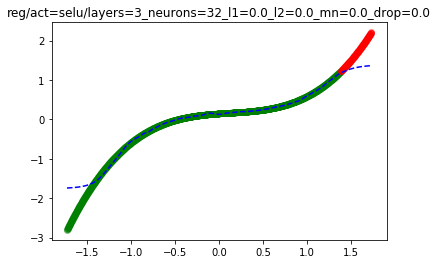

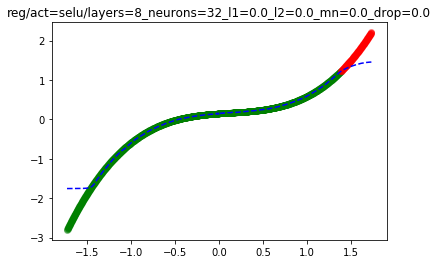

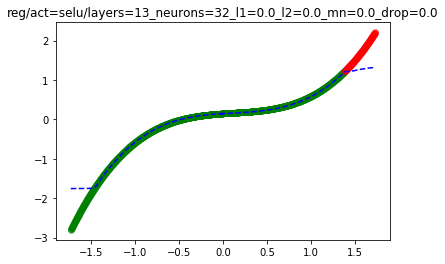

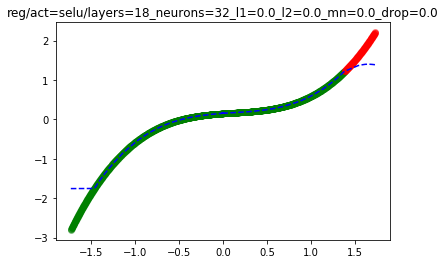

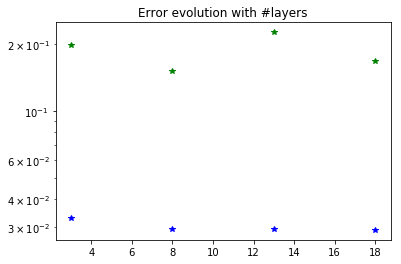

In [52]:
err_train = []
err_val = []
drop = 0.0

num_layers = np.arange(3, 20, 5)
for i in num_layers:
    _, et, ev = train_model_SN(layers=i, neurons=32, act='selu', lr=1e-5, drop_out=drop, 
                            epochs=600, batch_size=100, split=val_split, 
                            clear_session=True, log=True, plot=True, verbose=0)
    err_train.append(et)
    err_val.append(ev)
    
plt.title("Error evolution with #layers")
plt.semilogy(num_layers, err_train, '*b')
plt.semilogy(num_layers, err_val, '*g')
plt.show()

In [ ]:
<img src=""" style="float:center; width: 600px"/>